In [1]:
import os
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numba import jit
import pygmo as pg

In [2]:
funcs = {"sphere": 0, "schwefel": 1, "rosenbrock": 2, "rastrigin": 3, "griewank": 4, "ackley": 5}
funcs_dispname = {"sphere": "F1 : Shifted Sphere Function", 
                  "schwefel": "F2 : Schwefel’s Problem 2.21",
                  "rosenbrock": "F3 : Shifted Rosenbrock’s Function",
                  "rastrigin": "F4 : Shifted Rastrigin’s Function",
                  "griewank": "F5 : Shifted Griewank’s Function",
                  "ackley": "F6 : Shifted Ackley’s Function"}

In [3]:
def read_values(func):
    val_path = os.path.join('../data/', func_name + '.csv')
    bias_path = '../data/f_bias.csv'

    func_df = pd.read_csv(val_path)
    bias_df = pd.read_csv(bias_path)

    funcval = func_df.fvalue.values
    funcbias = bias_df.fvalue.values[funcs[func_name]]
    return funcval, funcbias

In [4]:
# function definitions

@jit(nopython=True)
def eval_fitness(x, dim):
    if func_name == "sphere":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z * z
        result = F + funcbias
    elif func_name == "schwefel":
        F = abs(x[0])
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F = max(F, abs(z))
        result = F + funcbias
    elif func_name == "rosenbrock":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z * z
        result = F + funcbias
    elif func_name == "rastrigin":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z ** 2 - 10 * math.cos(2 * math.pi * z) + 10
        result = F + funcbias
    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += math.cos(z / math.sqrt(i + 1))
        result = F1 - F2 + 1 + funcbias
    elif func_name == "ackley":
        Sum1 = 0
        Sum2 = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            Sum1 += z ** 2
            Sum2 += math.cos(2 * math.pi * z)
        result = -20 * math.exp(-0.2 * math.sqrt(Sum1 / dim)) - math.exp(Sum2 / dim) + 20 + math.e + funcbias
    else:
        result = 0
    return result


In [5]:
# Define problem Class
class My_problem:

    def __init__(self, dim, bounds, glob_opt):
        self.lower_bound = bounds[0]
        self.upper_bound = bounds[1]
        self.dimension = dim
        self.fitness_per_eval = []
        self.glob_opt = glob_opt

    def fitness(self, x):
        result = eval_fitness(x, self.dimension)
        return [result]

    def get_bounds(self):
        x_min = self.lower_bound * np.ones(self.dimension)
        x_max = self.upper_bound * np.ones(self.dimension)
        return x_min, x_max

In [6]:
def solve_pb(dim, my_algo, bounds, optim, popsize):
    prob = pg.problem(My_problem(dim, bounds, optim))
    pop = pg.population(prob, popsize)

    my_algo.set_verbosity(1)

    t1 = time.time()
    pop = my_algo.evolve(pop)
    t2 = time.time()

    time_diff = t2-t1
    
    if my_algo.get_name().split(":")[0] == "PSO":
        extract_algo = my_algo.extract(pg.pso)
    elif my_algo.get_name().split(":")[0] == "GACO":
        extract_algo = my_algo.extract(pg.gaco)
    elif my_algo.get_name().split(":")[0] == "DE":
        extract_algo = my_algo.extract(pg.de)
    elif my_algo.get_name().split(":")[0] == "saDE":
        extract_algo = my_algo.extract(pg.sade)
    elif my_algo.get_name().split(":")[0] == "IHS":
        extract_algo = my_algo.extract(pg.ihs)
    elif my_algo.get_name().split(":")[0] == "SGA":
        extract_algo = my_algo.extract(pg.sga)
    elif my_algo.get_name().split(":")[0] == "ABC":
        extract_algo = my_algo.extract(pg.bee_colony)
    
    
    log = extract_algo.get_log()
    curve = [x[2] for x in log]
    niter = log[-1][0]
    
    return pop, curve, niter, time_diff

In [23]:
def print_solution(dimension, my_algo, pop_evolved, log, niter, duration):
    algorithm_name = my_algo.get_name()
    parameters = my_algo.get_extra_info()
    solution_x = pop_evolved.champion_x
    fitness = pop_evolved.champion_f[0]
    n_evals = pop_evolved.problem.get_fevals()
    
    print("Function: %s" % funcs_dispname[func_name])
    print("Problem dimension: %d" % dimension)
    print("Global Optimum: %.2f\n" % funcbias)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters: \n%s\n" % parameters)
    print("Fitness: %f" % fitness)
    print("Solution: \n", solution_x)
    print("\nNb of functions evaluations: %d" % n_evals)
    print("Stopping criterion: after %d iterations" % niter)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log)
    plt.show()


In [24]:
# parameters
func_name = 'schwefel'
search_space = (-100, 100)

funcval, funcbias = read_values(func_name)

In [41]:
# Solve problem in dimension 50
DIM = 50

# define algorithm and parameters to use
algo = pg.algorithm(pg.pso(gen=1000))
pop_size = 300

# # define algorithm and parameters to use
# algo = pg.algorithm(pg.gaco(gen=500))
# pop_size = 150

# # define algorithm and parameters to use
# algo = pg.algorithm(pg.de(gen=500))
# pop_size = 150

# # define algorithm and parameters to use
# algo = pg.algorithm(pg.sga(gen=500))
# pop_size = 150

# # define algorithm and parameters to use
# algo = pg.algorithm(pg.bee_colony(gen=500))
# pop_size = 150

# # define algorithm and parameters to use
# algo = pg.algorithm(pg.sade(gen=500))
# pop_size = 150

# # define algorithm and parameters to use
# algo = pg.algorithm(pg.ihs(gen=500))
# pop_size = 150

Function: F2 : Schwefel’s Problem 2.21
Problem dimension: 50
Global Optimum: -450.00

Algorithm: PSO: Particle Swarm Optimization
Parameters: 
	Generations: 1000
	Omega: 0.7298
	Eta1: 2.05
	Eta2: 2.05
	Maximum velocity: 0.5
	Variant: 5
	Topology: 2
	Topology parameter: 4
	Memory: false
	Seed: 2289815714
	Verbosity: 1

Fitness: -433.014694
Solution: 
 [-14.73938511   1.18738445 -41.54398237 -80.52359716 -10.52989294
 -57.16399485  -9.66353364 -68.38636427 -76.08177056 -52.45036296
 -69.05662623 -62.57057672 -11.76363426 -33.01103974 -84.68388719
 -66.4791986  -40.69529468 -36.37185686 -69.39094109 -72.71372399
 -39.07600758 -65.71649363 -77.20596867 -68.23298233   5.37366106
 -29.20088151 -26.15160177 -79.16672218 -67.07098048 -30.12175208
 -76.80651845 -88.81682092 -37.85993594 -46.01402395 -79.78648658
 -96.25470638 -99.84600544 -42.02529785 -47.24102423 -57.73815626
 -21.12363287 -83.43068031 -23.46206392 -38.66407998  -2.37434273
 -90.21533889   2.81563328 -77.71359452 -43.68293721 

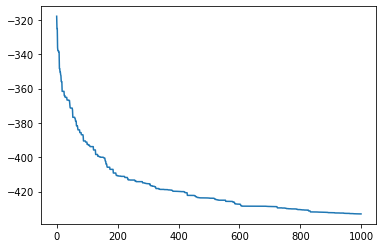

In [42]:

# run algorithm and print solution
pop_evolv, logs, nit, compute_time = solve_pb(dim=DIM, my_algo=algo, bounds=search_space, optim=funcbias, popsize=pop_size)
print_solution(dimension=DIM, my_algo=algo, pop_evolved=pop_evolv, log=logs, niter=nit, duration=compute_time)
